In [1]:
%load_ext autoreload
%autoreload 2
from DarkMatter import *

Welcome to JupyROOT 6.26/08


In [2]:
def GP_fit_with_bins(data, bins, color=None, label=None, pdf=True, sigma=1, ax=None, show_plot=False):
    
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

    y, x = np.histogram(data[:,0], bins)
    x_cnt = center_pt(np.log10(x))

    min_idx = np.argmax(y>0)
    max_idx = np.argmax(x_cnt[::-1]<5)
    selected_y = np.log1p(y[min_idx:(-max_idx)])
    selected_x = x_cnt[min_idx:(-max_idx)]
    kernel = C(1.0, (1e-4, 1e2)) * RBF(1.0, (1e-4, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-4, 1e2))

    # Fit the Gaussian Process model
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(selected_x.reshape(-1, 1), selected_y)

    # Predict using the Gaussian Process model
    x_pred_edges = np.linspace(2.6, 5, 1001)
    x_pred = center_pt(x_pred_edges).reshape(-1, 1)
    y_pred, error = gp.predict(x_pred, return_std=True)
    
    if show_plot:
        if pdf:
            etc = plt.step(10**x_cnt, y/sum(y)/(x[1:]-x[:-1]), where="mid", label=label, color=color)
            factor = sum((np.exp(y_pred)-1))*(10**x_pred_edges[1:]-10**x_pred_edges[:-1])
            plt.ylabel("Probability Density Function")
        else:
            etc = plt.step(10**x_cnt, y, where="mid", label=label, color=color)
            factor = 1
            plt.ylabel("Counts")
            plt.ylim(0.8, )

        plt.plot(10**x_pred, (np.exp(y_pred)-1)/factor, color=etc[0].get_color())
        plt.fill_between(10**x_pred[:, 0], (np.exp(y_pred - sigma*error)-1)/factor, (np.exp(y_pred + sigma*error)-1)/factor, alpha=0.2, color=etc[0].get_color())
        plt.xscale("log")
        plt.yscale("log")
        plt.xlim(80, 2e5)
        plt.xlabel("Energy [GeV]")

        plt.legend()
    return gp

In [44]:
def applyGP2Data(data, bins, data_type="energy", return_type="pdf", return_gp=False, rand=False, ax=None, show_plot=False, add_error=True, **kwargs):
    
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
    
    if data_type=="energy":
        y_cnt, x = np.histogram(data, bins)
        if rand:
            y_cnt = synthesize_counts(yarr)
    elif data_type=="counts":
        y_cnt = data
        x = bins
        
    if return_type == "pdf":
        y = y_cnt/sum(y_cnt)/(x[1:]-x[:-1])
    else:
        y = y_cnt
        
    x_cnt = center_pt(np.log10(x))

    non_zero_mask = (y != 0)
    selected_y = np.log10(y[non_zero_mask])
    selected_x = x_cnt[non_zero_mask]
    
    kernel = C(1.0, (1e-4, 1e2)) * RBF(1.0, (1e-4, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-4, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(selected_x.reshape(-1, 1), selected_y)
    
    if show_plot:
        sigma = kwargs.pop("sigma", 1)
        x_pred = np.linspace(np.log10(min(data)), np.log10(max(data)), 1000)
        y_pred, error = gp.predict(x_pred.reshape(-1,  1), return_std=add_error)
        
        if ax is None:
            ax = plt.gca()
        etc = ax.scatter(10**selected_x, 10**selected_y, marker="+", **kwargs)
        ax.plot(10**x_pred, 10**y_pred,  color=etc.get_edgecolor())
        if add_error:
            ax.fill_between(10**x_pred, 10**(y_pred - sigma*error), 10**(y_pred + sigma*error), alpha=0.2, color=etc.get_edgecolor())
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlim(80, 2e5)
        ax.set_ylabel("Probability Density Function")
        ax.set_xlabel("Energy [GeV]")
        ax.legend()
    if return_gp:
        return gp
    else:
        y_new = np.zeros(len(y_cnt))
        start_index = np.argmax(y_cnt != 0)
        x_new = x_cnt[start_index:]
        y_pred = gp.predict(x_new.reshape(-1,  1))
        y_new[start_index:]=y_pred
        y_new = 10**y_new
        y_new[y_new==1] = 0
        y_new[x_cnt>5] = 0
        print(x_cnt)
        return y_new
        
def bin_correction(data, bins, shift=False):
    if shift:
        bin_cnt = 10**center_pt(np.log10(bins))
        diff = np.log10(bin_cnt)[np.argmin(abs(shift-bin_cnt))]-np.log10(shift)
        bins = 10**(np.log10(bins)-diff)
    new_edges = bins[sum(bins<min(data))-1:]
    new_edges[0] = min(data)*(1-1e-5)
    return new_edges

def synthesize_counts(yarr):

    empty = True
    new_cnt = []
    for y in yarr:
        if y>0:
            empty=False

        if not(empty):
            new_cnt.append(np.random.poisson(lam=y))
        else:
            new_cnt.append(0)
    return np.array(new_cnt)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[1.025 1.075 1.125 1.175 1.225 1.275 1.325 1.375 1.425 1.475 1.525 1.575
 1.625 1.675 1.725 1.775 1.825 1.875 1.925 1.975 2.025 2.075 2.125 2.175
 2.225 2.275 2.325 2.375 2.425 2.475 2.525 2.575 2.625 2.675 2.725 2.775
 2.825 2.875 2.925 2.975 3.025 3.075 3.125 3.175 3.225 3.275 3.325 3.375
 3.425 3.475 3.525 3.575 3.625 3.675 3.725 3.775 3.825 3.875 3.925 3.975
 4.025 4.075 4.125 4.175 4.225 4.275 4.325 4.375 4.425 4.475 4.525 4.575
 4.625 4.675 4.725 4.775 4.825 4.875 4.925 4.975 5.025 5.075 5.125 5.175
 5.225 5.275 5.325 5.375 5.425 5.475 5.525 5.575 5.625 5.675 5.725 5.775
 5.825 5.875 5.925 5.975 6.025 6.075 6.125 6.175 6.225 6.275 6.325 6.375
 6.425 6.475 6.525 6.575 6.625 6.675 6.725 6.775 6.825 6.875 6.925 6.975]


array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.05898207e-03, 3.01314729e-03, 2.21314759e-03, 1.60938531e-03,
       1.15947673e-03, 8.28185891e-04, 5.86930040e-04, 4.13031018e-04,
       2.88852864e-04, 2.00928478e-04, 1.39143187e-04, 9.60136420e-05,
       6.60781393e-05, 4.53990260e-05, 3.11683692e-05, 2.14031922e-05,
       1.47149722e-05, 1.01385503e-05, 7.00720323e-06, 4.86271700e-06,
       3.39145479e-06, 2.37939095e-06, 1.68077394e-06, 1.19645663e-06,
      

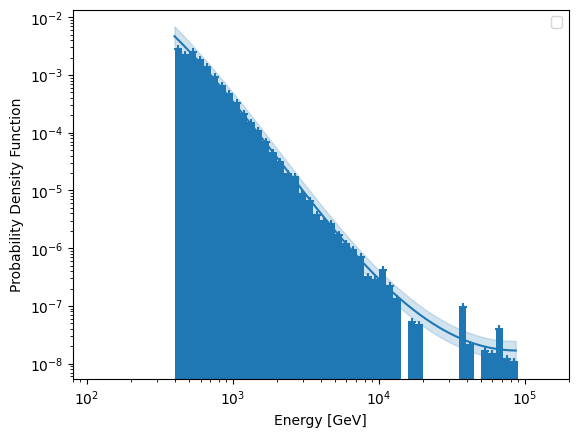

In [45]:
data = readData("UMa_II", ext=True, rawdata=True, biasFilter=True, effFilter=False)
plt.hist(data[:,0], np.logspace(1, 7, 121), density=True)
applyGP2Data(data[:,0], np.logspace(1, 7, 121), show_plot=True, return_type="pdf")


In [39]:
calcUpperLimits("UMa_II", "WINO", DM_spectra="WINO", ext=True, apply_gp=False, filename="UL_without_GP", mass=np.logspace(3, 4, 6))

[Log] Package      : EventDisplay
[Log] Dwarf        : UMa_II
[Log] Channel      : WINO
[Log] Dataset      : Extended (theta2=0.008)
[Log] Dimention    : 1
[Log] Background   : None
[Log] Dispersion   : Etr vs ratio
[Log] Minimum mass : 1000 GeV
[Log] Maximum mass : 10 TeV


  0%|          | 0/6 [00:00<?, ?it/s]

[Log] Upper limits are saved in '/Users/dtak/Research/DarkMatter/Output/UL_without_GP.npy'
 MNCONT UNABLE TO FIND FOUR POINTS.
 MNCONT UNABLE TO FIND FOUR POINTS.
 MNCONT UNABLE TO FIND FOUR POINTS.


Warning in <TMinuit::Contour>: Cannot find more than 4 points, no TGraph returned
Warning in <TMinuit::Contour>: Cannot find more than 4 points, no TGraph returned
Warning in <TMinuit::Contour>: Cannot find more than 4 points, no TGraph returned


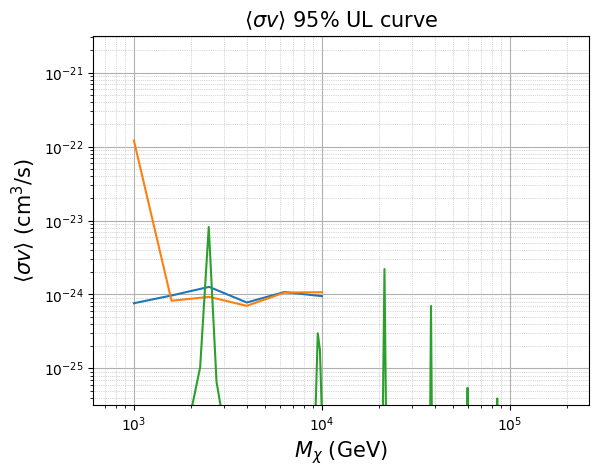

In [40]:
plotULcurve("UL_without_GP")
plotULcurve("UL_with_GP")
plotPredictedLine()

In [9]:
t1 = convertToPDF(data[1], gp=True)

Warning in <TROOT::Append>: Replacing existing TH1: th_1D (Potential memory leak).


In [10]:
t2 = convertToPDF(data[1])

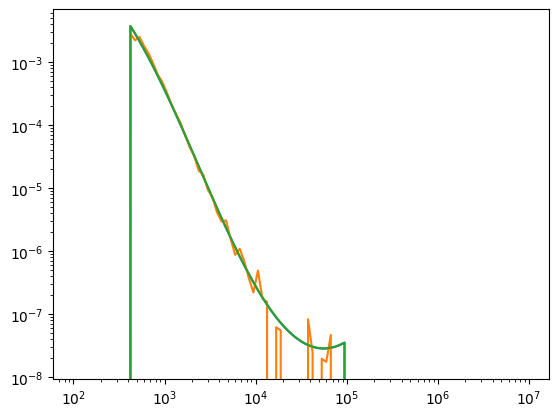

In [11]:
plt.plot(*getArray(t1))
plt.plot(*getArray(t2))
plt.xscale("log")
plt.yscale("log")
plt.plot(*getArray(h))


In [6]:
cnts, bins = getArray(data[1], return_edges=True)
new_cnts = convertToPDFwithGP(cnts, bins, return_pdf = True, data_type="counts")

In [7]:
h = convertHist(bins, new_cnts)

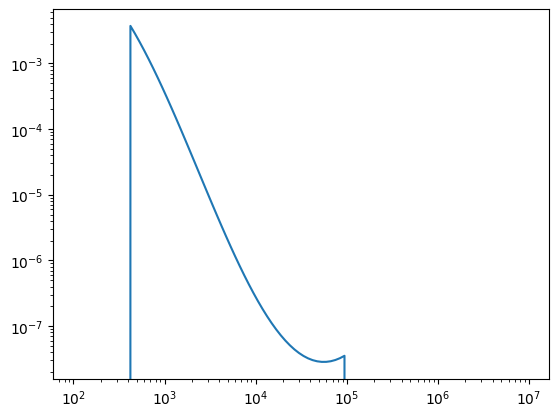

In [261]:
help(convertHist)

Help on function convertHist in module DarkMatter.utils:

convertHist(arr_x, arr_y)



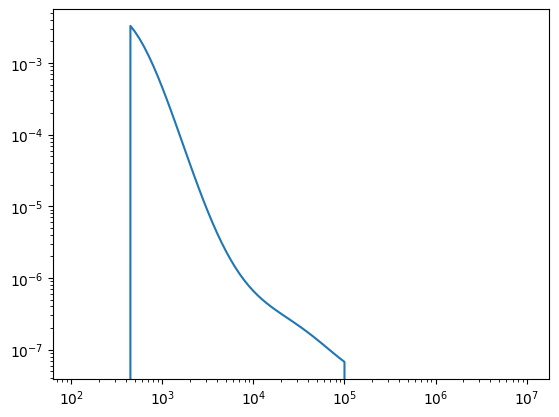

In [260]:
plt.plot(bins[1:], new_cnts)
plt.xscale("log")
plt.yscale("log")

In [99]:
from DarkMatter import *
data = readData("UMa_II", ext=True, rawdata=True)
bkg_data = data[data[:,2]==0]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(array([2.82813559e-03, 2.34892241e-03, 1.55022511e-03, 7.74718329e-04,
        3.92588153e-04, 1.79422611e-04, 8.63563520e-05, 3.73921686e-05,
        1.76161542e-05, 7.97276075e-06, 3.48960617e-06, 2.25857924e-06,
        9.78574507e-07, 5.18206240e-07, 3.60172617e-07, 1.63483017e-07,
        3.24647940e-08, 2.57877025e-08, 0.00000000e+00, 0.00000000e+00,
        5.16978691e-08, 1.02662693e-08, 3.26191502e-08, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]),
 array([3.98169266e+02, 4.47744228e+02, 5.63676586e+02, 7.09626778e+02,
        8.93367184e+02, 1.12468265e+03, 1.41589157e+03, 1.78250188e+03,
        2.24403691e+03, 2.82507509e+03

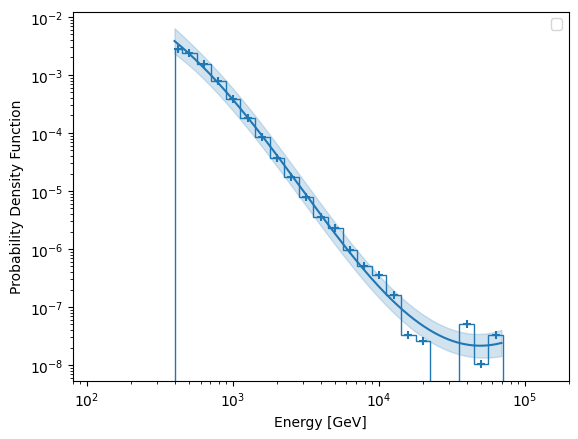

In [128]:
GP_fit_with_bins(bkg_data[:,0], bins, show_plot=True)
plt.hist(bkg_data[:,0], bins, density=True, histtype="step")

In [78]:
x = np.log10(np.geomspace(min(bkg_data[:,0]), max(bkg_data[:,0]), 101))

y_band = []
for i in trange(1000):
    
    gp = GP_fit_with_bins(bkg_data[:,0], bins, show_plot=False, add_error=False, rand=True)
    y_band.append(gp.predict(x.reshape(-1, 1)))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [155]:
y_band = np.asarray(y_band)

In [149]:
y_band = y_band.tolist()

In [150]:
np.concatenate(y_band)

array([-2.40452854, -2.45299796, -2.50270863, ..., -7.66600804,
       -7.66534518, -7.66287866])

In [156]:
gaussian_kde(y_band)

LinAlgError: 8-th leading minor of the array is not positive definite

In [159]:
a = 10

In [160]:
a.transform

AttributeError: 'int' object has no attribute 'transform'

In [161]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler

def fit_gp(x, y):
    # Standardize the data
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    x_scaled = x_scaler.fit_transform(x.reshape(-1, 1))
    y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))
    
    kernel = C(1.0, (1e-4, 1e2)) * RBF(1.0, (1e-4, 1e2)) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-5, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(x_scaled, y_scaled)
    
    return gp, x_scaler, y_scaler

def estimate_combined_pdf(gps, x_range, x_scalers, y_scalers):
    combined_predictions = []
    for gp, x_scaler, y_scaler in zip(gps, x_scalers, y_scalers):
        x_scaled = x_scaler.transform(x_range.reshape(-1, 1))
        y_pred, _ = gp.predict(x_scaled, return_std=True)
        y_pred = y_scaler.inverse_transform(y_pred)
        combined_predictions.append(y_pred)
    combined_predictions = np.concatenate(combined_predictions)
    kde = gaussian_kde(combined_predictions.flatten())
    return kde

def sample_from_kde(kde, num_samples=1):
    samples = kde.resample(num_samples)
    return samples

def plot_kde(kde, data, ax=None):
    if ax is None:
        ax = plt.gca()
    x = np.linspace(min(data), max(data), 1000)
    y = kde(x)
    ax.plot(x, y, label="Estimated PDF")
    ax.hist(data, bins=30, density=True, alpha=0.5, label="Histogram of GP predictions")
    ax.set_ylabel("Density")
    ax.set_xlabel("Data")
    ax.legend()
    plt.show()

# Example data: 1000 lines with 100 (x, y) points each
np.random.seed(42)
x_data = np.linspace(1, 10, 100)
lines = [np.random.lognormal(mean=2, sigma=0.5, size=100) for _ in range(1000)]

# Fit GPs for each line
gps = []
x_scalers = []
y_scalers = []

for line in lines:
    gp, x_scaler, y_scaler = fit_gp(x_data, line)
    gps.append(gp)
    x_scalers.append(x_scaler)
    y_scalers.append(y_scaler)

# Estimate combined PDF
x_range = np.linspace(1, 10, 1000)
kde = estimate_combined_pdf(gps, x_range, x_scalers, y_scalers)

# Plot the estimated PDF
all_gp_predictions = np.concatenate([
    y_scaler.inverse_transform(gp.predict(x_scaler.transform(x_range.reshape(-1, 1)))).flatten()
    for gp, x_scaler, y_scaler in zip(gps, x_scalers, y_scalers)
])
plot_kde(kde, all_gp_predictions)

# Sample from the estimated PDF
num_samples = 100
samples = sample_from_kde(kde, num_samples)
print(f"Generated {num_samples} samples: {samples}")

/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.w

/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/

/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.w

/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.w

/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings

/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.w

/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.w

/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/

/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.w

/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.w

/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.w

ValueError: Expected 2D array, got 1D array instead:
array=[ 9.56401370e-002  1.12793664e-257  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000 -1.25136733e-306 -3.61550169e-004 -1.45291883e-213
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  4.73826470e-010  6.48814240e-173  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  4.11973443e-020  1.92219988e-136
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
 -9.35921165e-036 -1.48797921e-105  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000 -8.61441748e-055 -4.66672038e-078
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  3.39214739e-077  6.26165086e-054  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  3.93005130e-105  2.47195536e-035
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
 -4.52830020e-137 -9.70523120e-021  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  5.11349543e-173  3.73436546e-010
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
 -3.22031404e-213 -8.01355906e-004 -2.77358631e-306  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000 -1.23633864e-257 -1.04831773e-001
 -1.23633864e-257  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  8.72819039e-307  2.52178448e-004  1.01339965e-213  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000 -9.41835635e-010
 -1.28966280e-172  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000 -2.35980149e-020 -1.10104431e-136  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000 -1.72921034e-035
 -2.74919419e-105  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000 -2.41773325e-054 -1.30976762e-077  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  3.58036579e-078
  6.60908798e-055  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000 -3.87217420e-105 -2.43555136e-035  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000 -9.75470619e-137
 -2.09066702e-020  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  2.00524790e-172  1.46442460e-009  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000 -1.95719801e-213
 -4.87037030e-004 -1.68569200e-306  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000 -6.74720753e-259 -5.72110020e-003 -6.74720753e-259
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000 -6.06420788e-306
 -1.75209575e-003 -7.04093963e-213  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000 -4.06448351e-010 -5.56552861e-173
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  3.28372282e-022  1.53213070e-138  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000 -2.86373431e-035 -4.55292312e-105
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  8.58982068e-055  4.65339547e-078  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000 -9.04402700e-078 -1.66945987e-054
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
 -1.72436301e-105 -1.08460375e-035  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000 -5.41787390e-137 -1.16118006e-020
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  2.86703781e-172  2.09378636e-009  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000 -6.94713007e-214 -1.72875180e-004
 -5.98341175e-307  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
 -2.21642137e-257 -1.87935063e-001 -2.21642137e-257  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  5.00522263e-306  1.44612940e-003
  5.81138890e-213  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000 -7.16435681e-010 -9.81020904e-173  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  2.32761950e-021
  1.08602872e-137  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000 -3.96618410e-035 -6.30565875e-105  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000 -2.89465695e-054
 -1.56813326e-077  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  1.62003230e-078  2.99045869e-055  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  3.73228655e-105
  2.34756370e-035  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  7.23507000e-138  1.55064868e-021  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000 -2.02923114e-173
 -1.48193947e-010  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000 -2.37394008e-213 -5.90740804e-004 -2.04462287e-306
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000 -2.75629991e-257
 -2.33712508e-001 -2.75629991e-257  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000 -3.81117872e-306 -1.10114135e-003 -4.42502629e-213
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
 -3.60257448e-010 -4.93303302e-173  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  2.44264570e-020  1.13969805e-136
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  8.20044151e-036  1.30375153e-105  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000 -3.44034604e-054 -1.86375144e-077
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  3.74992097e-078  6.92207419e-055  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000 -2.09383042e-105 -1.31699435e-035
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
 -5.89824236e-137 -1.26413452e-020  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  6.00909217e-173  4.38841621e-010
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  7.90332344e-213  1.96669481e-003  6.80696026e-306  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  2.63013855e-257  2.23015020e-001
  2.63013855e-257  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
 -4.25065576e-306 -1.22811685e-003 -4.93528771e-213  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000 -2.71662314e-010
 -3.71989302e-173  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  4.96778019e-021  2.31788399e-137  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  3.42058546e-035
  5.43823586e-105  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000 -1.41789562e-054 -7.68121863e-078  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000 -4.02531228e-078
 -7.43042600e-055  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000 -4.43392202e-105 -2.78888403e-035  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000 -8.76453053e-137
 -1.87844868e-020  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  8.79441299e-173  6.42252498e-010  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  1.16355526e-212
  2.89543774e-003  1.00214479e-305  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000 -4.04038720e-258 -3.42592990e-002 -4.04038720e-258
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  6.55867971e-306
  1.89496058e-003  7.61505357e-213  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  2.12555003e-010  2.91053206e-173
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
 -1.22107574e-020 -5.69733723e-137  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  8.82529630e-036  1.40309440e-105
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  6.01816279e-054  3.26024169e-077  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000 -1.94168769e-078 -3.58421054e-055
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  1.06655359e-104  6.70849478e-035  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000 -1.36878063e-136 -2.93362451e-020
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  8.93140541e-173  6.52257000e-010  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000 -4.83407255e-215 -1.20293007e-005
 -4.16348135e-308  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
 -9.03782075e-258 -7.66335968e-002 -9.03782075e-258  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000 -1.48422621e-308 -4.28828708e-006
 -1.72328313e-215  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000 -9.61701538e-010 -1.31686533e-172  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000 -5.74067904e-021
 -2.67850580e-137  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  8.67424370e-036  1.37907922e-105  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  5.67140942e-054
  3.07239369e-077  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000 -8.12893288e-078 -1.50054033e-054  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000 -3.56853663e-105
 -2.24456695e-035  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000 -4.75093416e-137 -1.01823891e-020  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  1.03331405e-172
  7.54625160e-010  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  1.64516582e-213  4.09389682e-004  1.41694547e-306
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000 -1.35686922e-257
 -1.15051816e-001 -1.35686922e-257  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  2.65530645e-306  7.67182004e-004  3.08298343e-213
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  2.01600940e-012  2.76053722e-175  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  2.16598337e-020  1.01061198e-136
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
 -2.02952745e-035 -3.22665494e-105  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000 -1.08190885e-054 -5.86106500e-078
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
 -6.65215299e-078 -1.22793779e-054  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000 -5.31531452e-105 -3.34326940e-035
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  1.95644818e-137  4.19313675e-021  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  1.76933765e-173  1.29214028e-010
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
 -5.77507618e-214 -1.43709320e-004 -4.97394728e-307  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000 -7.67674350e-258 -6.50927345e-002].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [158]:
xarr.trans

array([1.00000000e+01, 1.12201845e+01, 1.25892541e+01, 1.41253754e+01,
       1.58489319e+01, 1.77827941e+01, 1.99526231e+01, 2.23872114e+01,
       2.51188643e+01, 2.81838293e+01, 3.16227766e+01, 3.54813389e+01,
       3.98107171e+01, 4.46683592e+01, 5.01187234e+01, 5.62341325e+01,
       6.30957344e+01, 7.07945784e+01, 7.94328235e+01, 8.91250938e+01,
       1.00000000e+02, 1.12201845e+02, 1.25892541e+02, 1.41253754e+02,
       1.58489319e+02, 1.77827941e+02, 1.99526231e+02, 2.23872114e+02,
       2.51188643e+02, 2.81838293e+02, 3.16227766e+02, 3.54813389e+02,
       3.98107171e+02, 4.46683592e+02, 5.01187234e+02, 5.62341325e+02,
       6.30957344e+02, 7.07945784e+02, 7.94328235e+02, 8.91250938e+02,
       1.00000000e+03, 1.12201845e+03, 1.25892541e+03, 1.41253754e+03,
       1.58489319e+03, 1.77827941e+03, 1.99526231e+03, 2.23872114e+03,
       2.51188643e+03, 2.81838293e+03, 3.16227766e+03, 3.54813389e+03,
       3.98107171e+03, 4.46683592e+03, 5.01187234e+03, 5.62341325e+03,
      

In [157]:
help(np.transform)

AttributeError: module 'numpy' has no attribute 'transform'

In [ ]:
plt.plot(10**kde.resample()[0])

In [79]:
y_band = np.asarray(y_band)

In [80]:
y_percentile = []
for i in range(np.shape(y_band)[1]):
    y_percentile.append([np.percentile(y_band[:,i], 50), np.percentile(y_band[:,i], 16),np.percentile(y_band[:,i], 84)]) 
y_percentile = np.asarray(y_percentile)

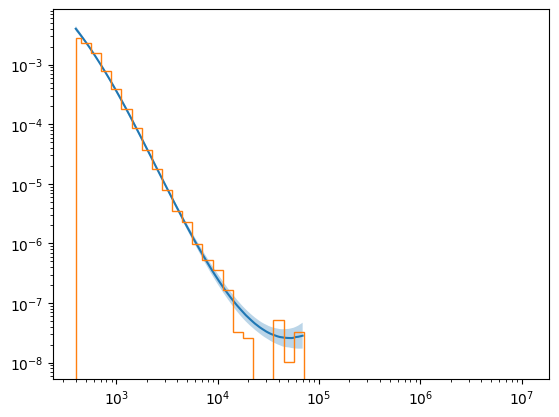

In [86]:
plt.plot(10**x, 10**y_percentile[:,0])
plt.fill_between(10**x, 10**y_percentile[:,1], 10**y_percentile[:,2], alpha=0.3)
plt.hist(bkg_data[:,0], bins, density=True, histtype="step")
plt.xscale("log")
plt.yscale("log")

In [129]:
from scipy.stats import gaussian_kde

In [133]:
help(gaussian_kde)

Help on class gaussian_kde in module scipy.stats._kde:

class gaussian_kde(builtins.object)
 |  gaussian_kde(dataset, bw_method=None, weights=None)
 |  
 |  Representation of a kernel-density estimate using Gaussian kernels.
 |  
 |  Kernel density estimation is a way to estimate the probability density
 |  function (PDF) of a random variable in a non-parametric way.
 |  `gaussian_kde` works for both uni-variate and multi-variate data.   It
 |  includes automatic bandwidth determination.  The estimation works best for
 |  a unimodal distribution; bimodal or multi-modal distributions tend to be
 |  oversmoothed.
 |  
 |  Parameters
 |  ----------
 |  dataset : array_like
 |      Datapoints to estimate from. In case of univariate data this is a 1-D
 |      array, otherwise a 2-D array with shape (# of dims, # of data).
 |  bw_method : str, scalar or callable, optional
 |      The method used to calculate the estimator bandwidth.  This can be
 |      'scott', 'silverman', a scalar constan

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)

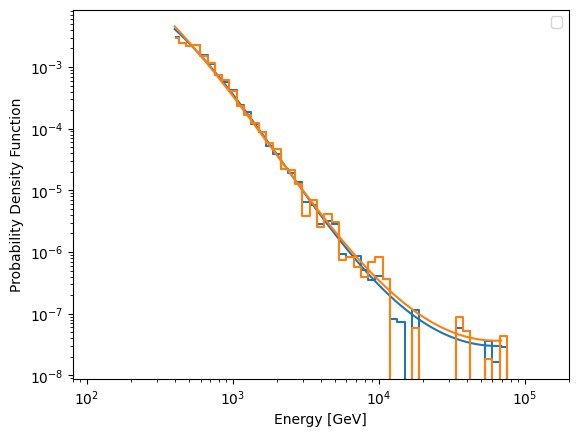

In [30]:
bins = bin_correction(bkg_data[:,0], np.logspace(1, 7, 121), shift=2e3)
GP_fit_with_bins(bkg_data[:,0], bins, show_plot=True, add_error=False)
GP_fit_with_bins(bkg_data[:,0], bins, show_plot=True, add_error=False, rand=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)

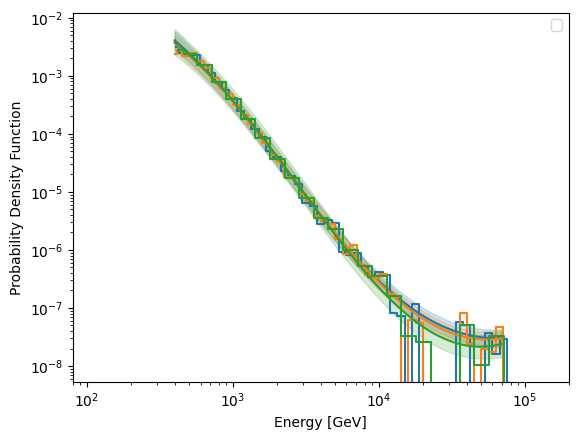

In [31]:
bins = bin_correction(bkg_data[:,0], np.logspace(1, 7, 121), shift=2e3)
GP_fit_with_bins(bkg_data[:,0], bins, show_plot=True)

bins = bin_correction(bkg_data[:,0], np.logspace(1, 7, 121), shift=3e3)
GP_fit_with_bins(bkg_data[:,0], bins, show_plot=True)

bins = bin_correction(bkg_data[:,0], np.logspace(1, 7, 61), shift=2e3)
GP_fit_with_bins(bkg_data[:,0], bins, show_plot=True)


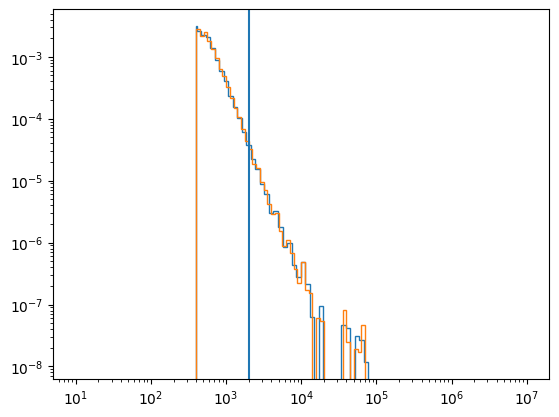

In [121]:
d = plt.hist(bkg_data[:,0], bins,density=True, histtype="step")
d = plt.hist(bkg_data[:,0], np.logspace(1, 7,121),density=True, histtype="step")
plt.xscale("log")
plt.yscale("log")
plt.axvline(2e3)

In [107]:
new_edges[0]

398.16926609130655

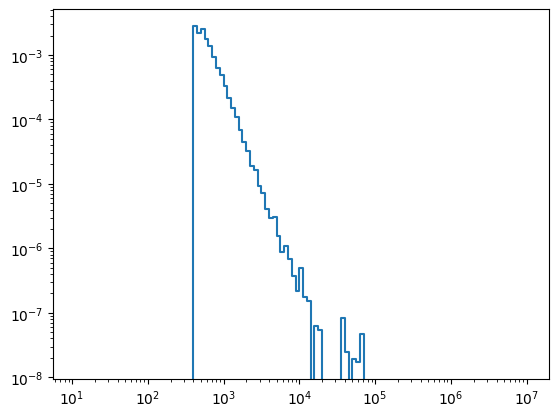

In [104]:
plt.step(x[1:], y)
plt.xscale("log")
plt.yscale("log")

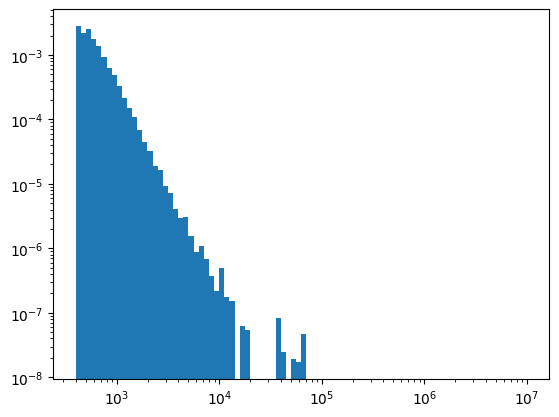

In [98]:
e = plt.hist(bkg_data[:,0], bins = new_edges, density=True)
plt.xscale("log")
plt.yscale("log")

In [83]:
new_edges

array([3.98107171e+02, 4.46683592e+02, 5.01187234e+02, 5.62341325e+02,
       6.30957344e+02, 7.07945784e+02, 7.94328235e+02, 8.91250938e+02,
       1.00000000e+03, 1.12201845e+03, 1.25892541e+03, 1.41253754e+03,
       1.58489319e+03, 1.77827941e+03, 1.99526231e+03, 2.23872114e+03,
       2.51188643e+03, 2.81838293e+03, 3.16227766e+03, 3.54813389e+03,
       3.98107171e+03, 4.46683592e+03, 5.01187234e+03, 5.62341325e+03,
       6.30957344e+03, 7.07945784e+03, 7.94328235e+03, 8.91250938e+03,
       1.00000000e+04, 1.12201845e+04, 1.25892541e+04, 1.41253754e+04,
       1.58489319e+04, 1.77827941e+04, 1.99526231e+04, 2.23872114e+04,
       2.51188643e+04, 2.81838293e+04, 3.16227766e+04, 3.54813389e+04,
       3.98107171e+04, 4.46683592e+04, 5.01187234e+04, 5.62341325e+04,
       6.30957344e+04, 7.07945784e+04, 7.94328235e+04, 8.91250938e+04,
       1.00000000e+05, 1.12201845e+05, 1.25892541e+05, 1.41253754e+05,
       1.58489319e+05, 1.77827941e+05, 1.99526231e+05, 2.23872114e+05,
      

In [70]:
x

array([1.00000000e+01, 1.12201845e+01, 1.25892541e+01, 1.41253754e+01,
       1.58489319e+01, 1.77827941e+01, 1.99526231e+01, 2.23872114e+01,
       2.51188643e+01, 2.81838293e+01, 3.16227766e+01, 3.54813389e+01,
       3.98107171e+01, 4.46683592e+01, 5.01187234e+01, 5.62341325e+01,
       6.30957344e+01, 7.07945784e+01, 7.94328235e+01, 8.91250938e+01,
       1.00000000e+02, 1.12201845e+02, 1.25892541e+02, 1.41253754e+02,
       1.58489319e+02, 1.77827941e+02, 1.99526231e+02, 2.23872114e+02,
       2.51188643e+02, 2.81838293e+02, 3.16227766e+02, 3.54813389e+02,
       3.98107171e+02, 4.46683592e+02, 5.01187234e+02, 5.62341325e+02,
       6.30957344e+02, 7.07945784e+02, 7.94328235e+02, 8.91250938e+02,
       1.00000000e+03, 1.12201845e+03, 1.25892541e+03, 1.41253754e+03,
       1.58489319e+03, 1.77827941e+03, 1.99526231e+03, 2.23872114e+03,
       2.51188643e+03, 2.81838293e+03, 3.16227766e+03, 3.54813389e+03,
       3.98107171e+03, 4.46683592e+03, 5.01187234e+03, 5.62341325e+03,
      

In [12]:
y, x = np.histogram(bkg_data[:,0], bins=np.logspace(1, 7, 121))
x_cnt = 10**center_pt(np.log10(x))

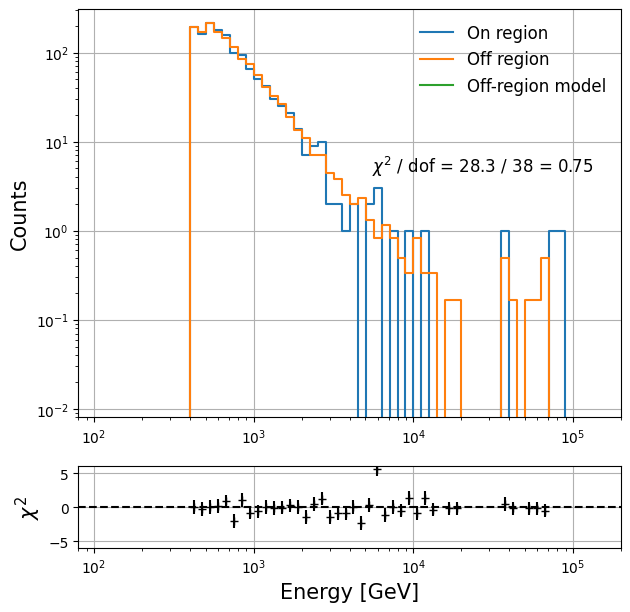

In [10]:
plotData("UMa_II", ext=True)

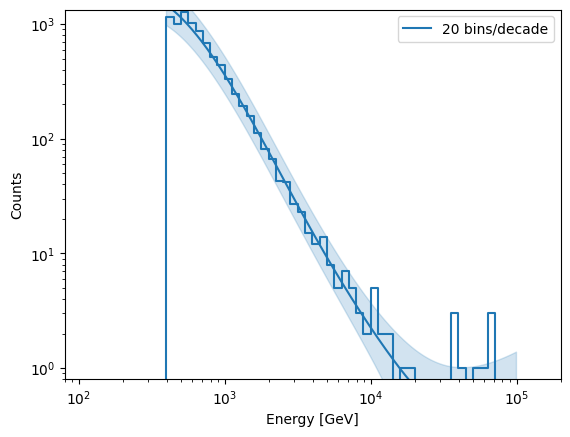

In [67]:
gp = GP_fit_with_bins(bkg_data, np.logspace(1, 7, 121), color="C0", label="20 bins/decade", pdf=False)

<ErrorbarContainer object of 3 artists>

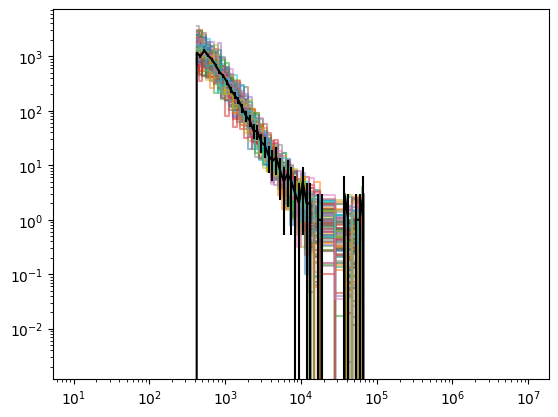

In [16]:
y_samp = gp.sample_y(np.log10(x_cnt[y>0].reshape(-1, 1)),n_samples=100 )

plt.step(x_cnt[y>0], np.exp(y_samp)-1, where="mid", alpha=0.5)
plt.xscale("log")
plt.yscale("log")
plt.errorbar(x_cnt, y, yerr=np.sqrt(y)*2, color="k")

(1e-09, 0.020231227523489926)

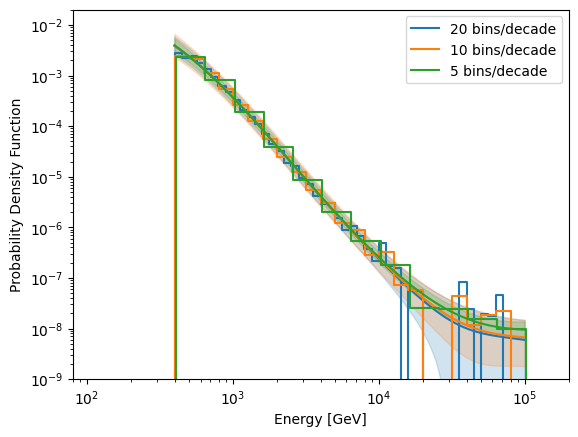

In [17]:
GP_fit_with_bins(bkg_data, np.logspace(1, 7, 121), color="C0", label="20 bins/decade")
GP_fit_with_bins(bkg_data, np.logspace(1, 7, 61), color="C1", label="10 bins/decade")
GP_fit_with_bins(bkg_data, np.logspace(1, 7, 31), color="C2", label="5 bins/decade")
plt.ylim(1e-9, )

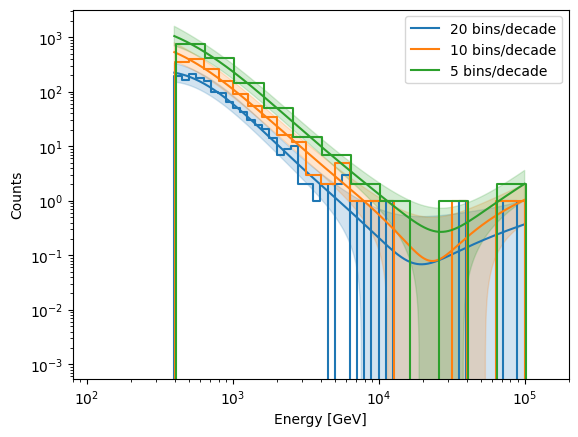

In [191]:
GP_fit_with_bins(bkg_data, np.logspace(1, 7, 121), color="C0", label="20 bins/decade", pdf=False)
GP_fit_with_bins(bkg_data, np.logspace(1, 7, 61), color="C1", label="10 bins/decade", pdf=False)
GP_fit_with_bins(bkg_data, np.logspace(1, 7, 31), color="C2", label="5 bins/decade", pdf=False)